#  The High-Resolution Rapid Refresh (HRRR) 

## Dataset description and why it’s a good kerchunk candidate

The HRRR is a NOAA real-time 3-km resolution, hourly updated, cloud-resolving, convection-allowing atmospheric model, initialized by 3km grids with 3km radar assimilation. Radar data is assimilated in the HRRR every 15 min over a 1-h period adding further detail to that provided by the hourly data assimilation from the 13km radar-enhanced Rapid Refresh.
NOAA releases a copy of this dataset via the AWS Registry of Open Data. While these data are stored in the cloud, they are stored in the GRIB2 file format, which does not allow asynronous reads. By generating a kerchunk index of this dataset, we can read it as if it were an Analysis-ready, cloud-optimized (ARCO) dataset.



In [1]:
import xarray as xr
import glob
import datetime as dt
import fsspec
import ujson
from kerchunk.grib2 import scan_grib
from kerchunk.combine import MultiZarrToZarr

## Create input file list

In [2]:
# Initiate fsspec filesystems for reading and writing
fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True)
fs_write = fsspec.filesystem('') 

# retrieve list of available days in archive
days_available = fs_read.glob('s3://noaa-hrrr-bdp-pds/hrrr.*')
# Read HRRR GRIB2 files from latest day
files = fs_read.glob(f's3://{days_available[-1]}/conus/*wrfsfcf01.grib2')
# Append s3 prefix for filelist
files = sorted(['s3://'+f for f in files])


## Iterate through filelist and create kerchunk indicies as .json files

In [5]:
# Note: scan_grib does not require a filter and will happily create a reference file for each available grib message. However when combining the grib messages using MultiZarrToZarr it is neccassary for the messages to share a coordinate system. Thus to make our lives easier and ensure all reference outputs from scan_grib share a coordinate system we pass a filter argument.
afilter={'typeOfLevel': 'heightAboveGround', 'level': [2, 10]}    
so = {"anon": True}
json_dir = '.'

def make_json_name(file_url, message_number): #create a unique name for each reference file
    date = file_url.split('/')[3].split('.')[1]
    name = file_url.split('/')[5].split('.')[1:3]
    return f'{json_dir}{date}_{name[0]}_{name[1]}_message{message_number}.json'

def gen_json(file_url):
    out = scan_grib(file_url, storage_options=so, filter=afilter)   #create the reference using scan_grib
    for i, message in enumerate(out): # scan_grib outputs a list containing one reference per grib message
        out_file_name = make_json_name(file_url, i)  #get name
        with fs_write.open(out_file_name, "w") as f: 
            f.write(ujson.dumps(message)) #write to file

In [9]:
# Iterate through available input files and generate json reference files. Note: This could optionally be parallelized.
for f in files:
    gen_json(f)

reference_jsons = sorted(fs_write.glob(json_dir + '*.json')) #get list of file names


100%|███████████████████████████████████████████| 19/19 [17:39<00:00, 55.77s/it]


## Combine .json kerchunk reference files and write a combined kerchunk index

In [19]:
#combine individual references into single consolidated reference
mzz = MultiZarrToZarr(reference_jsons,
                        concat_dims = ['valid_time'],
                        identical_dims=['latitude', 'longitude', 'heightAboveGround', 'step'])
multi_kerchunk = mzz.translate()

## Load kerchunked dataset

In [20]:
# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo=multi_kerchunk, remote_protocol='s3', remote_options={'anon':True})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={'valid_time':1})

In [21]:
ds

<xarray.Dataset>
Dimensions:            (valid_time: 19, x: 1059, y: 1799, heightAboveGround: 1,
                        step: 1, time: 1)
Coordinates:
  * heightAboveGround  (heightAboveGround) int64 2
  * step               (step) timedelta64[ns] 01:00:00
  * time               (time) datetime64[ns] 2022-11-02
  * valid_time         (valid_time) datetime64[ns] 2022-11-02T01:00:00 ... 20...
Dimensions without coordinates: x, y
Data variables:
    10si               (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    10u                (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    10v                (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    2d                 (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    2r                 (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    2sh                (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    2t                 (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    latitude           (x, y) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    longitude          (x, y) float64 dask.array<chunksize=(1059, 1799), meta=np.ndarray>
    pt                 (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
    unknown            (valid_time, x, y) float64 dask.array<chunksize=(1, 1059, 1799), meta=np.ndarray>
Attributes:
    centre:             kwbc
    centreDescription:  US National Weather Service - NCEP
    edition:            2
    subCentre:          0

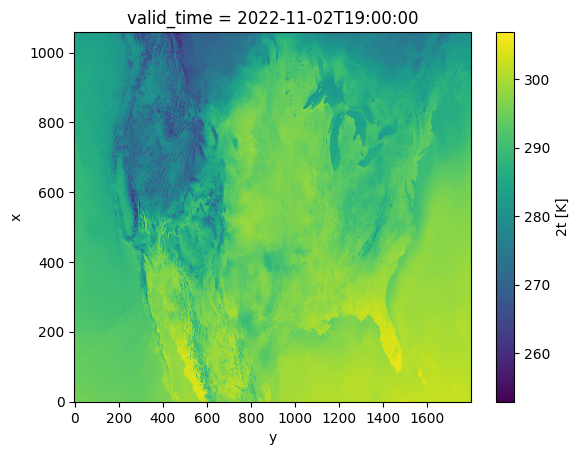

In [22]:
ds['2t'][-1].plot()

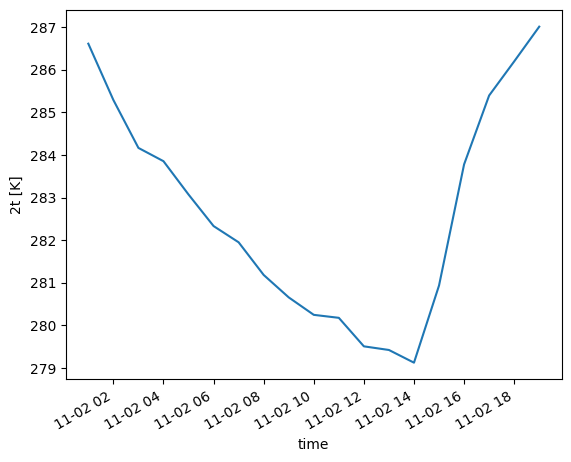

In [23]:
ds['2t'][:,500,500].plot()